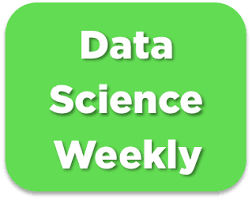

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [58]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [59]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [7]:
data.shape

(284580, 6)

In [4]:
data["converted"].value_counts()

0    275400
1      9180
Name: converted, dtype: int64

In [5]:
data.describe(include="all")
#there are no missing values -> no need to pre process features replacing na
# there are categorical and numeric features, we will need to standardise and encode features
#the target value is "converted", it's categrocial with 1 or 0 values and no missing values. no need to label encode it. Note that the dataset is unbalanced interm of proportion of 0 and 1 

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [8]:
#exploring the data set

In [9]:
data.groupby('country').mean()

,age,new_user,total_pages_visited,converted
country,,,,
China,30.664014,0.699126,4.551604,0.001288
Germany,30.457966,0.678012,5.207646,0.062431
UK,30.433675,0.678559,5.078985,0.052497
US,30.564450,0.681971,4.931609,0.037908


In [10]:
data.groupby('source').mean()

,age,new_user,total_pages_visited,converted
source,,,,
Ads,30.530059,0.686418,4.901183,0.034801
Direct,30.550510,0.686152,4.815493,0.027814
Seo,30.590183,0.684572,4.884174,0.032873


In [11]:
data.groupby('new_user').mean()

,age,total_pages_visited,converted
new_user,,,
0,30.421722,5.282660,0.071933
1,30.629587,4.685378,0.014052


# EDA

In [12]:
# The dataset is quite big : we must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [13]:
px.histogram(data_sample["converted"]) #very unbalanced sample in term of target value

In [15]:
px.histogram(data_sample["country"]) #the dataset is not balanced as many of users come from USA

In [16]:
px.histogram(data_sample["age"])

In [18]:
px.scatter(data_sample, x = 'total_pages_visited', y = 'age', color = data_sample['converted'].astype('str'), labels = {'color': 'converted'})
# --> more converted clients among those who visited many pages 

In [19]:
px.scatter(data_sample, x = 'total_pages_visited', y = 'age', color = data_sample['new_user'].astype('str'), labels = {'color': 'new_user'})

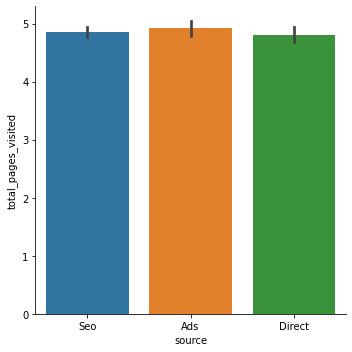

In [22]:
#visualize total pages visited by source of visit to the website --> not a notable difference 
sns.catplot(x="source", y='total_pages_visited', data=data_sample, kind="bar")

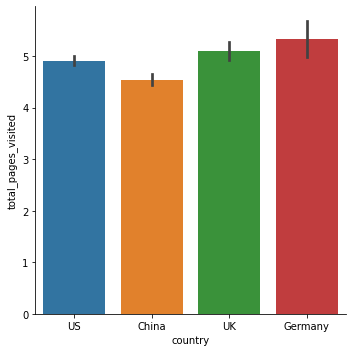

In [24]:
#visualize total pages visited by country --> not a notabme difference --> visitors from Germanu have visite dmore pages
sns.catplot(x="country", y='total_pages_visited', data=data_sample, kind="bar")

# Make your model

## Choose variables to use in the model, and create train and test sets
## The target variable is categorical (0 or 1) : it's a classification problem

In [61]:
data.columns.tolist()

['country', 'age', 'new_user', 'source', 'total_pages_visited', 'converted']

In [26]:
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
numeric_indices = [1,4]
categorical_indices = [0,2,3]
target_variable = 'converted'

In [27]:
#separating fetaures from target variable
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [28]:
# Divide dataset into Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [29]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['US' 20 1 'Ads' 4]
 ['China' 29 1 'Ads' 3]
 ['US' 36 0 'Seo' 3]
 ['US' 23 1 'Seo' 8]
 ['UK' 41 1 'Ads' 3]]
[['US' 32 1 'Seo' 4]
 ['UK' 30 1 'Seo' 5]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder

# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Create pipeline for numeric features

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler()) #normalisation des fetaures quantitaive autours de la moyenn
])

# Create pipeline for categorical features

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

Encoding categorical features and standardizing numerical features...


In [31]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

In [32]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions

print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[['US' 20 1 'Ads' 4]
 ['China' 29 1 'Ads' 3]
 ['US' 36 0 'Seo' 3]
 ['US' 23 1 'Seo' 8]
 ['UK' 41 1 'Ads' 3]]
...Done.
[[-1.27650481 -0.2618471   0.          0.          1.          1.
   0.          0.        ]
 [-0.18867057 -0.56090876  0.          0.          0.          1.
   0.          0.        ]
 [ 0.65742272 -0.56090876  0.          0.          1.          0.
   0.          1.        ]
 [-0.9138934   0.93439955  0.          0.          1.          1.
   0.          1.        ]
 [ 1.26177508 -0.56090876  0.          1.          0.          1.
   0.          0.        ]]

Performing preprocessings on test set...
[['US' 32 1 'Seo' 4]
 ['UK' 30 1 'Seo' 5]
 ['China' 31 1 'Seo' 5]
 ['US' 51 0 'Seo' 5]
 ['US' 20 1 'Direct' 3]]
...Done.
[[ 0.17394084 -0.2618471   0.          0.          1.          1.
   0.          1.        ]
 [-0.0678001   0.03721457  0.          1.          0.          1.
   0.          1.        ]
 [ 0.05307037  0.03721457

In [33]:
# Train model of adaboost with default parameters
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier()
classifier.fit(X_train, Y_train)
print("...Done.")
print(f"score Adaboost default train {classifier.score(X_train, Y_train)}")
print(f"score Adaboost default test {classifier.score(X_test, Y_test)}")

...Done.
score Adaboost default train 0.9856455126853609
score Adaboost default test 0.9858739194602573


In [64]:
# --> very hight R2-score which is not suprising as the dataset is unbalanced. therefore it's more interesting to use the f1-score in this case

In [34]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [35]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [41]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set with Adaboost: ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set with Adaboost: ", f1_score(Y_test, Y_test_pred))

f1-score on train set with Adaboost:  0.7484605911330049
f1-score on test set with Adaboost:  0.750465549348231


In [42]:
# We can also check more performance metrics to better understand what the model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219534    786]
 [  2482   4862]]

Confusion matrix on test set : 
[[54903   177]
 [  627  1209]]



**The Adaboost model reaches a f1-score of almost 75%. And it is not overfitting. That is satistfying and better than the baselne model build by the competition team  f1-score of 70%)

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [43]:
# Concatenate our train and test set to train the best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

AdaBoostClassifier()

In [44]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [45]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")
print("Performing preprocessings on test set without labels...")
print(X_without_labels[0:5,:])
X_without_labels = preprocessor.transform(X_without_labels)
print('...Done.')
print(X_without_labels[0:5,:])
print()

Encoding categorical features and standardizing numerical features...
Performing preprocessings on test set without labels...
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]
...Done.
[[-0.30954104  3.32689285  0.          1.          0.          0.
   0.          1.        ]
 [-1.03476387  0.03721457  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17394084 -1.15903208  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17394084  0.33627623  0.          0.          1.          1.
   0.          0.        ]
 [-0.67215246 -0.56090876  0.          0.          0.          0.
   0.          1.        ]]



In [47]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('test_predictions_adboost_all.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a AdaBoost Model with all the features in the dataset. We can analyse feature imporance now. 


In [62]:
#calculate coefficient features 
classifier.feature_importances_
features = [c for c in data.columns.tolist() if c!="converted"]
print (features)
coef_dataframe = pd.DataFrame.from_dict(dict(zip(features, classifier.feature_importances_)), orient='index', columns=["coefficients"])
print(coef_dataframe)

['country', 'age', 'new_user', 'source', 'total_pages_visited']
                     coefficients
country                      0.10
age                          0.60
new_user                     0.06
source                       0.12
total_pages_visited          0.10


In [63]:
#compute the absolute value and order the coefficients
coef_dataframe.apply(lambda x : abs(x)).sort_values(by="coefficients", ascending=False)
#day of the month, temperature and month are the most important features to predict the weekly sales of a store

,coefficients
age,0.60
source,0.12
country,0.10
total_pages_visited,0.10
new_user,0.06


In [ ]:
# --> age appears to be the most imporant feature in the model